In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from pathlib import Path
import pylangacq
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
import nltk
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxreuter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the corpora into individual readers, plus a combined reader.
# Loading may take several seconds.

SINGLE_STUDY = "Garvey"

data_path = Path('data')
corpora_paths = sorted(data_path.glob('*.zip'), key=lambda x: x.name.lower())
corpora_names = [path.stem for path in corpora_paths]

data = {'studies': {study: {'reader': pylangacq.read_chat(str(path))}
                    for study, path in zip(corpora_names, corpora_paths)}}

print(f"Corpora loaded:\n    {'\n    '.join(data['studies'].keys())}")

Corpora loaded:
    Garvey


In [3]:
# Extract the names/IDs of child participants who were present for the fully longitude of their respective study,
# and set them as keys in that study's dictionary.

def extract_participant_ids(study, reader):
    # Extract the filenames without path or extension
    filenames = [re.search(r'(?<=\/)[^\/]+(?=\.cha)', path).group() for path in reader.file_paths()]
    
    if study == 'Bates':        
        cleaned_filenames = []
        for filename in filenames:
            filename = re.sub(r'\d+',       '', filename)  # Remove numbers
            filename = re.sub(r'st$',       '', filename)  # Remove 'st' if it appears at the end
            filename = re.sub(r'snack$',    '', filename)  # Remove 'snack' if it appears at the end
            filename = re.sub(r'[^a-zA-Z]', '', filename)  # Remove non-alphabetical characters
            cleaned_filenames.append(filename)
        
        # Filter filenames that don't appear in all 4 sessions
        return sorted([filename for filename, count in Counter(cleaned_filenames).items() if count == 4])
    elif study == 'Champaign':
        # Filter filenames that don't appear in all 12 sessions
        return sorted([filename for filename, count in Counter(filenames).items() if count == 12])
    elif study == 'HSLLD':
        return sorted(list(set([filename[:3] for filename in filenames])))
    return sorted(list(set(filenames)))

print('Number of children present for the full longitude of the study:')
total = 0
for study in data['studies'].keys():
    data['studies'][study]['children'] = {}
    child_ids = extract_participant_ids(study, data['studies'][study]['reader'])
    print(f'    {study:<9} n={len(child_ids)}')
    for child_id in child_ids:
        data['studies'][study]['children'][child_id] = {'transcripts': {}}
        total += 1
print(f'    ---------------\n    {'Total':<9} N={total}')

Number of children present for the full longitude of the study:
    Garvey    n=45
    ---------------
    Total     N=45


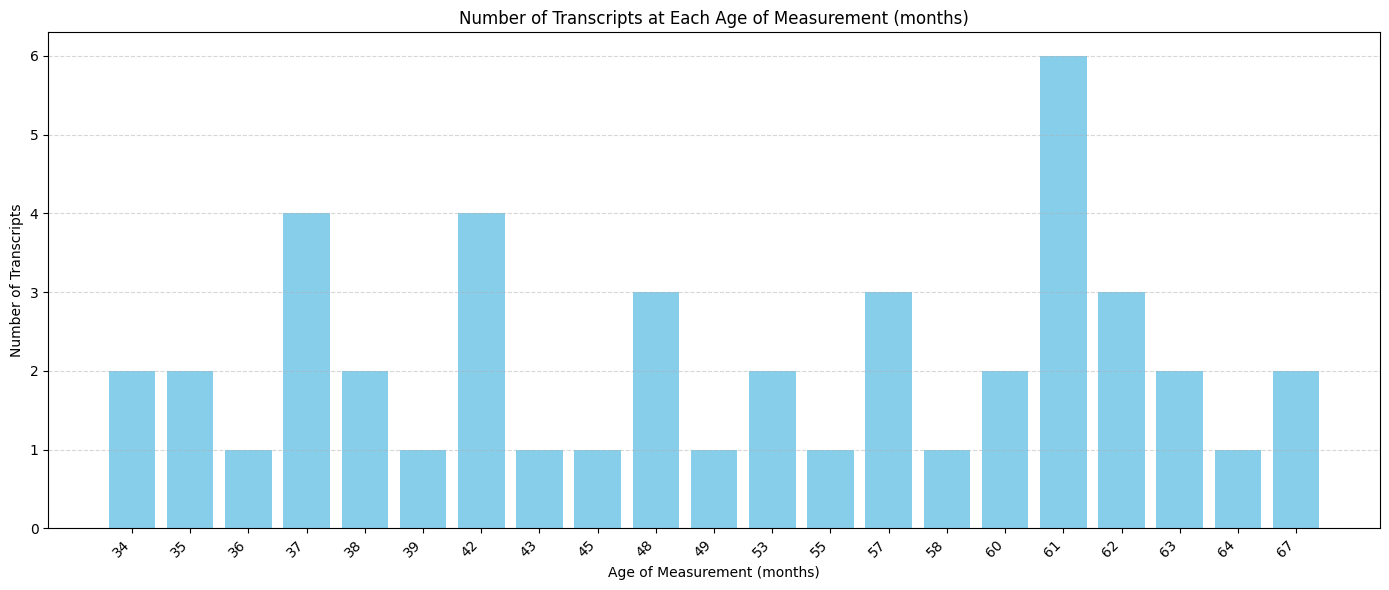

In [4]:
# Determine the ages at which data is available, rounding to the nearest month.

# Calculate unique rounded ages.
ages_of_measurement = sorted(
    round(age_of_measurement) 
    for data in data['studies'].values() 
    if 'reader' in data 
    for age_of_measurement in data['reader'].ages(months=True) 
    if age_of_measurement not in [None, 0]
)
data['ages_of_measurement'] = {age_of_measurement: {
    'male':   {'readers': [], 'transcripts': []},
    'female': {'readers': [], 'transcripts': []},
    } for age_of_measurement in ages_of_measurement}

# Plot the number of children in each age bucket.
age_of_measurement_counter = Counter(ages_of_measurement)
ages = [str(age) for age, _ in age_of_measurement_counter.items()]
counts = [count for _, count in age_of_measurement_counter.items()]

plt.figure(figsize=(14, 6))  # Increase figure size for clarity
plt.bar(ages, counts, color='skyblue')  # Use a visually appealing color

# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for better legibility
plt.xlabel('Age of Measurement (months)')
plt.ylabel('Number of Transcripts')
plt.title('Number of Transcripts at Each Age of Measurement (months)')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines

# Adjust the layout
plt.tight_layout()  # Prevent x-tick labels from being cut off

plt.show()

In [5]:
# Organize the transcripts by child, age, and gender.
# This may take over 2 minutes.

num_invalid_ages = 0
num_valid_ages = 0
num_invalid_genders = 0
num_valid_genders = 0

data['genders'] = {'male': pylangacq.Reader(), 'female': pylangacq.Reader()}
for study in data['studies'].keys():
    for child_id in data['studies'][study]['children'].keys():
        child_reader = pylangacq.read_chat(f'data/{study}.zip', match=child_id)

        # Extract the gender of the child
        try:
            gender = child_reader.headers()[0]['Participants']['CHI']['sex']
            if gender == '':
                data['studies'][study]['children'][child_id]['gender'] = None
                num_invalid_genders += 1
                continue
            data['studies'][study]['children'][child_id]['gender'] = gender
            num_valid_genders += 1
        except KeyError:
            data['studies'][study]['children'][child_id]['gender'] = None
            num_invalid_genders += 1
            continue
        
        # Extract the ages of measurement of the child
        for age_of_measurement_reader in child_reader:
            ages_of_measurement = age_of_measurement_reader.ages(months=True)
            assert len(ages_of_measurement) == 1
            age_of_measurement = ages_of_measurement[0]
            
            # Check for valid ages and skip invalid ones
            if age_of_measurement in [None, 0]:
                num_invalid_ages += 1
                continue
            else:
                num_valid_ages += 1

            age_of_measurement = round(age_of_measurement)
            data['ages_of_measurement'][age_of_measurement][gender]['readers'].append(age_of_measurement_reader)
            data['genders'][gender].append(age_of_measurement_reader)
            data['studies'][study]['children'][child_id]['transcripts'].setdefault(age_of_measurement, []).append(age_of_measurement_reader)

print(f'Discarded {num_invalid_ages} readers with invalid ages ({round(100 * num_invalid_ages / (num_invalid_ages + num_valid_ages))}%).')
print(f'Discarded {num_invalid_genders} invalid genders ({round(100 * num_invalid_genders / (num_invalid_genders + num_valid_genders))}%).')

Discarded 0 readers with invalid ages (0%).
Discarded 0 invalid genders (0%).


In [6]:
# Calculate the gender distribution per study.

num_total_males = num_total_females = num_total_unspecified = 0
print('Gender distribution per study:')

for name, corpus in data['studies'].items():
    gender_counts = Counter(child['gender'] if child['gender'] in ['male', 'female'] else 'unspecified' 
                            for child in corpus['children'].values())
    num_males, num_females, num_unspecified = gender_counts.get('male', 0), gender_counts.get('female', 0), gender_counts.get('unspecified', 0)
    
    total = num_males + num_females + num_unspecified
    num_males_percentage, num_females_percentage, num_unspecified_percentage = [
        round(100 * count / total) for count in (num_males, num_females, num_unspecified)
    ]
    
    num_total_males += num_males
    num_total_females += num_females
    num_total_unspecified += num_unspecified

    print(f'    {name:<9} {num_males_percentage}%m, {num_females_percentage}%f ({num_unspecified_percentage}% unsp.)')

total_all = num_total_males + num_total_females + num_total_unspecified
total_males_percentage, total_females_percentage, total_unspecified_percentage = [
    round(100 * count / total_all) for count in (num_total_males, num_total_females, num_total_unspecified)
]

print('    ---------------------------------')
print(f'    {"Total":<9} {total_males_percentage}%m, {total_females_percentage}%f ({total_unspecified_percentage}% unsp.)')

Gender distribution per study:
    Garvey    53%m, 47%f (0% unsp.)
    ---------------------------------
    Total     53%m, 47%f (0% unsp.)


In [7]:
# Extract the transcripts by age and gender.

male_transcripts_count = 0
female_transcripts_count = 0

ages_of_measurement_buckets = data['ages_of_measurement'].keys()
for age_of_measurement in ages_of_measurement_buckets:
    for gender in ['male', 'female']:
        data['ages_of_measurement'][age_of_measurement][gender]['transcripts'] = [
            {
                'child': ' '.join(reader.words(participants='CHI')),
                'parent': ' '.join(reader.words(participants=['MOT', 'FAT']))
            }
            for reader in data['ages_of_measurement'][age_of_measurement][gender]['readers']
        ]

    male_transcripts_count   += sum(len(data['ages_of_measurement'][age_of_measurement][gender]['transcripts']) for gender in ['male', 'female'] if gender == 'male')
    female_transcripts_count += sum(len(data['ages_of_measurement'][age_of_measurement][gender]['transcripts']) for gender in ['male', 'female'] if gender == 'female')

percent_male   = round(100 * male_transcripts_count   / (male_transcripts_count + female_transcripts_count))
percent_female = round(100 * female_transcripts_count / (male_transcripts_count + female_transcripts_count))
print(f'\nTotal number of transcripts:\n    Male   child: {male_transcripts_count} ({percent_male}%)\n    Female child: {female_transcripts_count} ({percent_female}%)')


Total number of transcripts:
    Male   child: 24 (53%)
    Female child: 21 (47%)


In [8]:
# Print the top n-grams for male vs. female children.
# This may take several minutes.

ngram_ns = [3]
ngrams = {n: {'male': {'child': None, 'parent': None}, 'female': {'child': None, 'parent': None}} for n in ngram_ns}
for n in ngrams.keys():
    for gender in ['male', 'female']:
        for participant, roles in {'child': ['CHI'], 'parent': ['MOT', 'FAT']}.items():
            ngrams[n][gender][participant] = Counter({
                ngram: count
                for ngram, count in data['genders'][gender].word_ngrams(n=n, participants=roles).items()
                if all(word not in string.punctuation for word in ngram)
            })
    print(f'Completed calculations for {n}-grams.')

Completed calculations for 3-grams.


/Users/maxreuter/miniconda3/envs/cse881/lib/python3.12/site-packages/matplotlib_venn/layout/venn3/pairwise.py:103: UserWarning: Circle A has zero area.
  warnings.warn("Circle A has zero area.")
/Users/maxreuter/miniconda3/envs/cse881/lib/python3.12/site-packages/matplotlib_venn/layout/venn3/pairwise.py:111: UserWarning: Circle C has zero area.
  warnings.warn("Circle C has zero area.")


AttributeError: 'NoneType' object has no attribute 'set_text'

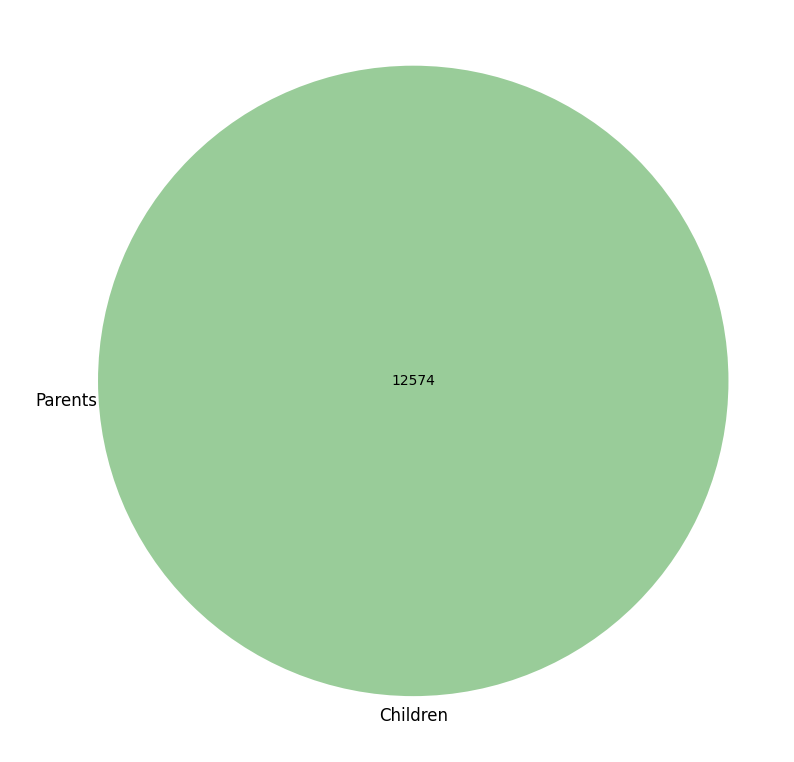

In [9]:
# Print information about n-grams common among and unique between genders and parents/children.
# In its current state, this may not be very informative because it seems the female n-grams have a high
# frequency of "The Very Hungry Caterpillar" readings.

def generate_corrected_venn_diagram(group_a_counter, group_b_counter, group_a, group_b):
    top_group_a_ngrams = set([ngram for ngram, _ in group_a_counter.most_common(40)])
    top_group_b_ngrams = set([ngram for ngram, _ in group_b_counter.most_common(40)])

    group_a_unique = [ngram for ngram in group_a_counter.keys() if ngram not in top_group_b_ngrams]
    group_b_unique = [ngram for ngram in group_b_counter.keys() if ngram not in top_group_a_ngrams]
    group_a_b_common = group_b_counter.keys() & group_a_counter.keys()

    group_a_unique_top10   = sorted(group_a_unique,   key=lambda x: group_a_counter[x], reverse=True)[:10]
    group_b_unique_top10   = sorted(group_b_unique,   key=lambda x: group_b_counter[x], reverse=True)[:10]
    group_a_b_common_top10 = sorted(group_a_b_common, key=lambda x: min(group_b_counter[x], group_a_counter[x]), reverse=True)[:10]

    group_a_unique_str   = "\n".join([f"{' '.join(ngram)}" for ngram in group_a_unique_top10])
    group_b_unique_str   = "\n".join([f"{' '.join(ngram)}" for ngram in group_b_unique_top10])
    group_a_b_common_str = "\n".join([f"{' '.join(ngram)}" for ngram in group_a_b_common_top10])

    # Plot the Venn diagram
    plt.figure(figsize=(10, 10))
    venn = venn3(
        subsets=(len(group_a_unique), len(group_b_unique), len(group_a_b_common), 0, 0, 0, 0),
        set_labels=(group_a, group_b)
    )

    # Customize the Venn diagram with examples
    venn.get_label_by_id('100').set_text(f"{group_a_unique_str}")
    venn.get_label_by_id('010').set_text(f"{group_b_unique_str}")
    venn.get_label_by_id('110').set_text(f"{group_a_b_common_str}")

    plt.title(f'Top N-grams Among {group_a} and {group_b}')
    plt.show()

generate_corrected_venn_diagram(
    Counter(ngrams[3]['male']['parent']) + Counter(ngrams[3]['female']['parent']),
    Counter(ngrams[3]['male']['child']) + Counter(ngrams[3]['female']['child']),
    'Parents',
    'Children'
)

generate_corrected_venn_diagram(
    Counter(ngrams[3]['male']['child']),
    Counter(ngrams[3]['female']['child']),
    'Boys',
    'Girls'
)

In [ ]:
# Bucket child transcripts by age of measurement.

child_transcripts_by_age = {
    age_of_measurement: [
        item['child'] for gender in ['male', 'female']
        for item in data['ages_of_measurement'][age_of_measurement][gender]['transcripts']
    ]
    for age_of_measurement in ages_of_measurement_buckets
    if data['ages_of_measurement'][age_of_measurement]
}

num_total_transcripts = sum(len(child_transcripts) for child_transcripts in child_transcripts_by_age.values())
num_buckets = len(child_transcripts_by_age)
average_transcripts_per_bucket = round(num_total_transcripts / num_buckets)
print(f'Organized {num_total_transcripts} transcripts into {num_buckets} buckets (~{average_transcripts_per_bucket}/bucket).')

Organized 2388 transcripts into 76 buckets (~31/bucket).


In [ ]:
# Remove stopwords and other common words from the transcripts.

def preprocess_texts(document_texts):
    omit = set(nltk.corpus.stopwords.words('english'))
    omit.update([
        # Yes/no variants
        'yes', 'yep', 'yea', 'yeah', 'uhhuh', 'mhm', 'okay', 'no', 'nope', 'na',
        # Exclamations
        'oh', 'ah', 'mm', 'hm', 'huh', 'uhoh',
        # Hi/bye
        'hi', 'hey', 'bye',
        # Parent references
        'mom', 'mama', 'mommy', 'dad', 'dada', 'daddy',
        # Common words
        'thats', 'get', 'got', 'like', 'want', 'put', 'see', 'go', 'right', 'look', 'hafta', 'wanna', 
        # Common verbs
        'dont', 'gonna',
        # Numbers
        'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
        # Noises
        'zzz',
        # Unfamiliar tokens
        '0is'
    ])

    def preprocess(text):
        if isinstance(text, str):
            text = re.sub(r'[^\w\s]', '', text.lower())  # Lowercase and remove punctuation
            return " ".join([word for word in text.split() if word not in omit])
        return ""

    # Flatten nested lists and preprocess
    flat_texts = [doc for sublist in document_texts for doc in sublist] if isinstance(document_texts[0], list) else document_texts
    
    # Preprocess the remaining texts
    return [preprocess(doc) for doc in [doc for doc in flat_texts]]

ages = sorted(child_transcripts_by_age.keys())
document_texts = [child_transcripts_by_age[age] for age in ages]
processed_texts = preprocess_texts(document_texts)

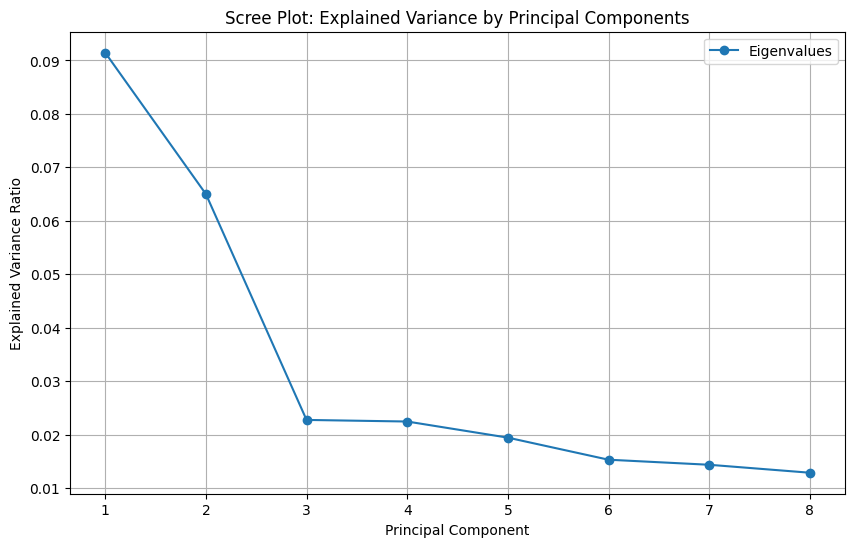

In [ ]:
# Perform PCA to help determine a good number of components (i.e. topics/concepts) to use for LDA.

def perform_pca(doc_term_matrix):
    # Perform PCA
    pca = PCA()
    pca.fit(doc_term_matrix.toarray())  # Convert sparse matrix to dense for PCA
    
    # Plot the eigenvalues (explained variance) for the first 90 components
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 9), explained_variance[:8], marker='o', label="Eigenvalues")
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot: Explained Variance by Principal Components')
    plt.legend()
    plt.grid()
    plt.show()

    # Return PCA components for further analysis if needed
    return pca

vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(processed_texts)
pca = perform_pca(doc_term_matrix)

In [ ]:
# Cluster the documents into topics/concepts using LDA.
import math
def train_lda(processed_texts, n_topics):
    vectorizer = CountVectorizer()
    doc_term_matrix = vectorizer.fit_transform(processed_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(doc_term_matrix)
    return lda, vectorizer, doc_term_matrix


def display_results(lda, vectorizer, doc_term_matrix, ages, document_texts, n_top_words=20, window_size=3):
    """
    Display results and assign custom labels from topic_labels.
    """
    print("Discovered Topics:")
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    # Open a text file to write the topics to
    with open(f"results/{SINGLE_STUDY}/topics.txt", "w") as f:
        for topic_idx, topic in enumerate(lda.components_):
            # Extract the top features for each topic
            top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
            label = f'Topic {topic_idx}'
            topics.append((label, top_features))
            print(f"{label}: {', '.join(top_features)}")
            f.write(f"{label}: {', '.join(top_features)}\n")

    topic_words = ""
    topic_words += "\nTopic 1: " + ', '.join(topics[0][1])
    topic_words += "\nTopic 2: " + ', '.join(topics[1][1])
    topic_words += "\nTopic 3: " + ', '.join(topics[2][1])
    topic_words += "\nTopic 4: " + ', '.join(topics[3][1])

    from openai import OpenAI
    client = OpenAI(api_key="KEY_GOES_HERE")

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"The following are features gathered during clustering when analyzing a study concerning child language acquisition. Based on the words in the clusters, assign 1 theme (no more than 2 words) to each of the {len(topic_words)} topics: {topics}. Put the themes inside double carets (<< >>)."
            }
        ]
    )

    pattern = r"<<(.*?)>>"
    topic_labels = re.findall(pattern, completion.choices[0].message.content)

    # Compute document-topic distributions
    doc_topic_distributions = lda.transform(doc_term_matrix)

    expanded_ages = []
    for age, docs in zip(ages, document_texts):
        expanded_ages.extend([age] * len(docs))
    
    # Ensure lengths match
    assert len(expanded_ages) == doc_topic_distributions.shape[0], \
        f"Length mismatch: expanded_ages ({len(expanded_ages)}) and doc_topic_distributions ({doc_topic_distributions.shape[0]})"

    # Create DataFrame
    df = pd.DataFrame(doc_topic_distributions, index=expanded_ages, columns=topic_labels)
    df_topic_proportions = df.groupby(level=0).mean()

    # Plot smoothed topic proportions
    smoothed = df_topic_proportions.rolling(window=window_size, center=True).mean()
    plt.figure(figsize=(12, 8))
    for column in smoothed.columns:
        plt.plot(smoothed.index, smoothed[column], label=column)
    plt.xlabel("Age in Months")
    plt.ylabel("Smoothed Topic Proportion")
    plt.title(f"Smoothed Topic Proportions Across Ages (Window Size = {window_size})")
    plt.legend()
    plt.savefig(f"results/{SINGLE_STUDY}/topics.png")
    plt.close()

    # Return the top words for each topic as a list of tuples
    return topic_labels


# Train LDA
lda, vectorizer, doc_term_matrix = train_lda(processed_texts, n_topics=4)

# Define custom topic labels
my_list = ["Food and Animals", "Mealtime Words", "Play and Actions", "Daily Routines"]

# Get and print the top words per topic
topic_labels = display_results(lda, vectorizer, doc_term_matrix, ages, document_texts, window_size=math.floor(len(ages)/3))

print(topic_labels)

Discovered Topics:
Topic 0: im, know, car, blue, red, yellow, whats, cars, big, hello, wheres, eat, theres, green, cup, school, bus, come, play, going
Topic 1: ate, hungry, caterpillar, still, butterfly, read, cat, little, leaf, slice, moon, egg, hes, know, big, piece, cake, cocoon, apple, dog
Topic 2: im, know, make, wait, watch, come, ill, lets, something, try, play, stick, cant, little, hes, whoa, take, going, theyre, think
Topic 3: know, im, good, eat, didnt, said, ill, well, write, went, little, going, love, cant, big, done, say, come, please, think
['Objects & Colors', 'Storytelling & Hunger', 'Activities & Play', 'Communication & Actions']


In [ ]:
# Organize transcripts by age of measurement and child ID for a specific study.

study_ages_of_measurement = set()
for child_id in list(data['studies'][SINGLE_STUDY]['children'].keys()):
    study_ages_of_measurement.update(data['studies'][SINGLE_STUDY]['children'][child_id]['transcripts'].keys())

child_transcripts_by_age_of_measurement = {age: {} for age in study_ages_of_measurement}
for age in study_ages_of_measurement:
    for child in list(data['studies'][SINGLE_STUDY]['children'].keys()):
        if age in data['studies'][SINGLE_STUDY]['children'][child]['transcripts']:
            child_transcripts_by_age_of_measurement[age][child] = preprocess_texts([' '.join(reader.words(participants='CHI')) for reader in data['studies'][SINGLE_STUDY]['children'][child]['transcripts'][age]])
        else:
            child_transcripts_by_age_of_measurement[age][child] = []

In [ ]:
# Define some helper functions for future use.

# Predict Topics for New Transcripts
def predict_topic(lda, vectorizer, new_transcripts):
    # Transform new transcripts into the LDA's vectorizer space
    X_new = vectorizer.transform(new_transcripts)

    # Get topic probabilities for each new transcript
    topic_distributions = lda.transform(X_new)

    # Assign the topic with the highest probability
    predicted_topics = np.argmax(topic_distributions, axis=1)

    return predicted_topics, topic_distributions

def barycentric_coordinates(topic_distributions):
    """
    Map topic distributions into 2D barycentric coordinates.
    Place the simplex corners correctly for 4 topics in a rotated square layout.
    """
    # Define the 2D coordinates for the corners of the rotated square
    corners = np.array([
        [-1, 1],  # Topic 1 (Top-left)
        [1, 1],   # Topic 2 (Top-right)
        [1, -1],  # Topic 3 (Bottom-right)
        [-1, -1]  # Topic 4 (Bottom-left)
    ])

    # Normalize the topic distributions to sum to 1
    topic_distributions = topic_distributions / topic_distributions.sum(axis=1, keepdims=True)

    # Compute the weighted sum of the simplex corners based on topic probabilities
    points = np.dot(topic_distributions, corners)
    return points, corners


def plot_participant_topics_on_simplex_with_tracking(lda, vectorizer, participant_transcripts, most_recent_locations, age, topic_labels):
    """
    Predict topics for participants and plot them on a 2D simplex.
    Participants without transcripts in the current age are plotted with muted colors.
    Participants with 'G' in their name are pink, and those with 'B' are blue.
    The corners of the simplex are labeled using meaningful topic labels.
    """
    # Extract transcripts and their IDs
    participants_with_transcripts = list(participant_transcripts.keys())
    transcripts = list(participant_transcripts.values())

    # Predict topic distributions for participants with transcripts
    _, topic_distributions = predict_topic(lda, vectorizer, transcripts)

    # Update most recent locations for participants with transcripts
    for i, participant_id in enumerate(participants_with_transcripts):
        most_recent_locations[participant_id] = topic_distributions[i]

    # Combine points for participants with and without transcripts
    all_points = []
    all_labels = []
    all_colors = []

    # Participants with transcripts
    points_with_transcripts, corners = barycentric_coordinates(topic_distributions)
    for i, participant_id in enumerate(participants_with_transcripts):
        if "G" in participant_id:
            color = 'pink'
        elif "B" in participant_id:
            color = 'blue'
        else:
            color = 'green'  # Default color for participants without G or B
        all_points.append(points_with_transcripts[i])
        all_labels.append(participant_id)
        all_colors.append(color)

    # Participants without transcripts
    participants_without_transcripts = [
        participant_id for participant_id in most_recent_locations.keys() if participant_id not in participants_with_transcripts
    ]
    if participants_without_transcripts:
        missing_points = np.array([most_recent_locations[participant_id] for participant_id in participants_without_transcripts])
        missing_points, _ = barycentric_coordinates(missing_points)
        for i, participant_id in enumerate(participants_without_transcripts):
            if "G" in participant_id:
                color = 'lightpink'  # Muted pink
            elif "B" in participant_id:
                color = 'lightblue'  # Muted blue
            else:
                color = 'lightgreen'  # Default muted color
            all_points.append(missing_points[i])
            all_labels.append(participant_id)
            all_colors.append(color)

    # Convert all points to a NumPy array for plotting
    all_points = np.array(all_points)

    # Plot the simplex
    plt.figure(figsize=(12, 10))
    plt.scatter(all_points[:, 0], all_points[:, 1], c=all_colors, s=100, alpha=0.7)

    # Annotate points with participant IDs
    for i, participant_id in enumerate(all_labels):
        plt.annotate(participant_id, (all_points[i, 0], all_points[i, 1]), fontsize=10, ha='center', va='center')

    # Plot simplex corners with meaningful labels
    for i, (x, y) in enumerate(corners):
        plt.scatter(x, y, c='red', s=200, label=topic_labels[i])  # Use the passed topic labels
        plt.annotate(topic_labels[i], (x, y), fontsize=12, fontweight='bold', ha='center', va='center')

    # Add grid, title, and labels
    plt.title(f"2D Representation of Participant Topic Distributions (Age: {age})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(alpha=0.5)

    # Save the plot as a PNG file
    plt.savefig(f"results/{SINGLE_STUDY}/clusters/age_{age}.png")
    plt.close()


In [ ]:
# Assuming `top_words_per_topic` is a list of tuples returned from `display_results`
# Example: [("Topic 1", ["baby", "pooh", "bubble", ...]), ...]

# Create topic labels from the first two words of each topic
most_recent_locations = {}
for age in sorted(child_transcripts_by_age_of_measurement.keys()):
    age_transcripts = {}
    for child_id in sorted(child_transcripts_by_age_of_measurement[age].keys()):
        # Flatten transcripts for each child
        flattened_transcripts = ' '.join(child_transcripts_by_age_of_measurement[age][child_id])
        if flattened_transcripts.strip():  # Only add if there's actual text
            age_transcripts[child_id] = flattened_transcripts

    # Call the updated function with topic labels
    plot_participant_topics_on_simplex_with_tracking(
        lda, vectorizer, age_transcripts, most_recent_locations, age, topic_labels
    )
